In [209]:
import sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import datetime as dt
import yfinance as yf
import seaborn as sns   

plt.style.use('ggplot')

### Data Preprocessing

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Fechamento BTC-USD'}, xlabel='Date'>

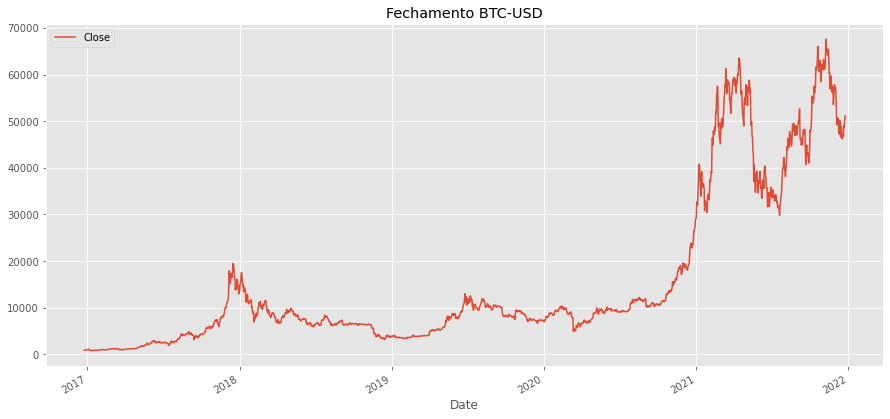

In [210]:
# Loading the dataset
p = '5y'
i = '1d'

df = yf.download(tickers='BTC-USD', period = p, interval = i)
df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot(figsize=(15,7), title="Fechamento BTC-USD", legend=True)

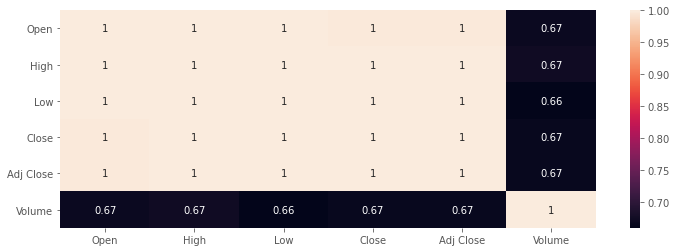

Open         0.998526
High         0.999360
Low          0.999238
Close        1.000000
Adj Close    1.000000
Volume       0.667078
Name: Close, dtype: float64

In [211]:
# Matriz de correlação
plt.figure(figsize=(12,4))
sns.heatmap(df.corr(), annot = True)

plt.show()
df.corr()['Close']

In [212]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    1.826000e+03
mean     2.096004e+10
std      2.121853e+10
min      6.085170e+07
25%      4.505265e+09
50%      1.630156e+10
75%      3.261215e+10
max      3.509679e+11
Name: Volume, dtype: float64


In [213]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

## Funções do modelo

In [214]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [215]:
#Contrói e treina o modelo
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    #Dados de treino e validação
    X_train, Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
    
    # Adiciona as camadas do modelo
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
        model.add(Dropout(0.2))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Treinamento
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [216]:
# Função para avaliar o modelo
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Laço para os dados de teste
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Predição
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [217]:
# Função para plotar os dados de teste e predição
def plot_data(Y_test,Y_hat):
    plt.figure(figsize=(15,7))
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Fechamento')
    plt.title("Predição LSTM-M")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [218]:
# Função para plotar erro
def plot_error(train_loss,val_loss):
    plt.figure(figsize=(15,7))
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Construção do Modelo

In [219]:
# Extraindo as séries
features = ['Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(1826, 4)
                   Close          Open           Low          High
Date                                                              
2021-12-19  46707.015625  46853.867188  46502.953125  48089.664062
2021-12-20  46880.277344  46707.062500  45579.808594  47401.718750
2021-12-21  48936.613281  46886.078125  46698.773438  49300.917969
2021-12-22  48628.511719  48937.097656  48450.941406  49544.796875
2021-12-24  51169.457031  50856.691406  50711.500000  51169.457031


In [220]:
# Sepração de treino, validação e teste
qt_teste = 120

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1586, 4) (120, 4) (120, 4)


In [221]:
# Normalização dos dados
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1586, 4) (120, 4) (120, 4)


In [222]:
sc.scale_

array([1.59424287e-05, 1.59366167e-05, 1.62725433e-05, 1.56152915e-05])

In [223]:
close_scale = 1/sc.scale_[0]
close_scale

62725.70001220703

## Hiperparâmetros

In [224]:
timesteps = 2
hl = [50, 80, 130, 210]
lr = 1e-3
batch_size = 64
num_epochs = 250

In [225]:
# for t in [2,3,5,8,13,21]:
#     print("\n\nTimestep: "+str(t))
#     model,train_error,val_error = fit_model(train,val,t,hl,lr,batch_size,num_epochs)
#     mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,t)
#     print('MAE = {}'.format(mae))
#     print('MSE = {}'.format(mse))
#     print('RMSE = {}'.format(rmse))
#     print('R2 Score = {}'.format(r2_value))


In [226]:
#sys.exit()

Epoch 00133: early stopping


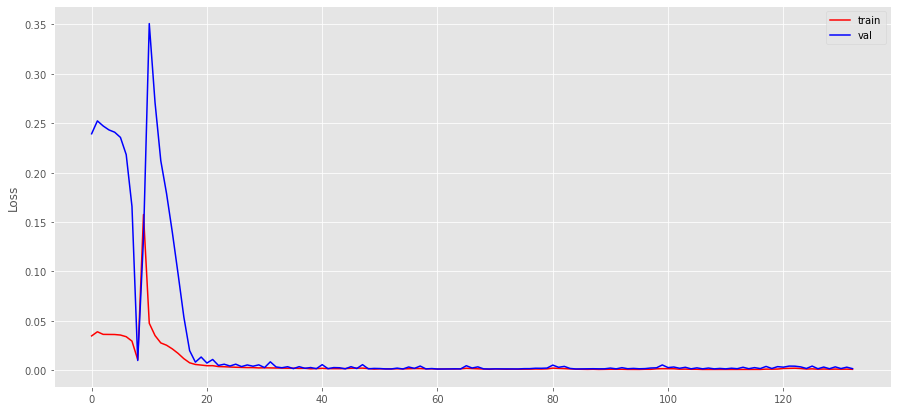

In [227]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.05849211081179418
MSE = 0.0050413285721306305
RMSE = 0.07100231385054033
R2 Score = 0.609468150136895


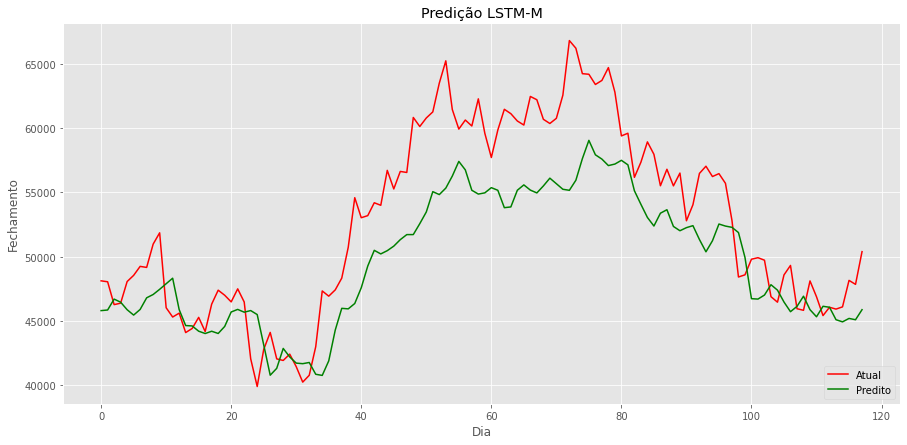

In [228]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R2 Score = {}'.format(r2_value))
plot_data(true*close_scale,predicted*close_scale)

## Validação Cruzada

In [229]:
# Menor número de épocas
num_epochs = 100

In [230]:
# Extraindo as séries
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(1826, 4)
                   Close          Open           Low          High
Date                                                              
2021-12-19  46707.015625  46853.867188  46502.953125  48089.664062
2021-12-20  46880.277344  46707.062500  45579.808594  47401.718750
2021-12-21  48936.613281  46886.078125  46698.773438  49300.917969
2021-12-22  48628.511719  48937.097656  48450.941406  49544.796875
2021-12-24  51169.457031  50856.691406  50711.500000  51169.457031


In [231]:
# Normalização
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.00181265, 0.00220147, 0.00198974, 0.00147385],
       [0.00177313, 0.00186409, 0.00162539, 0.00112328],
       [0.00194422, 0.00182296, 0.00215069, 0.00132238],
       ...,
       [0.72105893, 0.69054596, 0.70007014, 0.71325934],
       [0.71644588, 0.72126154, 0.72676931, 0.71684757],
       [0.75449021, 0.75000893, 0.76121523, 0.74075147]])

In [232]:
close_scale = 1/sc.scale_[0]
close_scale

66789.07110595703

### Função para validação forward walk usando lote 

In [233]:
def cross_val_forward_walk_batch(splits,split_size, series):
    cross_val_results = list()
    for i in range(splits):
        train = series[:(3+i)*split_size]
        test = series[(3+i)*split_size:(4+i)*split_size]
        X_train,Y_train = to_sequential_data(train, timesteps)
        start = time.time()
        history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
        end = time.time()  
        
        mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
        print("Split "+str(i+1))
        print('MAE = {}'.format(mae))
        print('MSE = {}'.format(mse))
        print('RMSE = {}'.format(rmse))
        print('R-Squared Score = {}'.format(r2_value))
        plot_data(true*close_scale,predicted*close_scale)
        cross_val_results.append([mae, mse,rmse,r2_value,end-start])
        
    return cross_val_results

Split 1
MAE = 0.011069376538580724
MSE = 0.00021358371065583658
RMSE = 0.014614503435144028
R-Squared Score = 0.8750991294565215


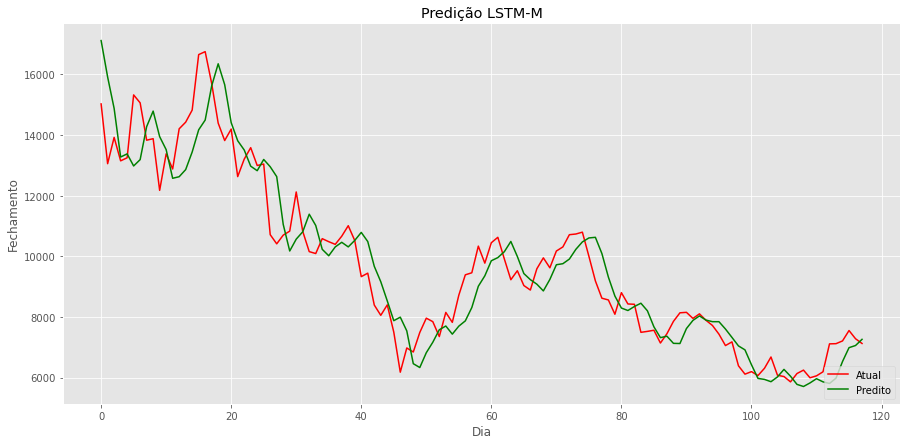

Split 2
MAE = 0.005194058333681935
MSE = 4.491645676422776e-05
RMSE = 0.006701974094565553
R-Squared Score = 0.8256446227279102


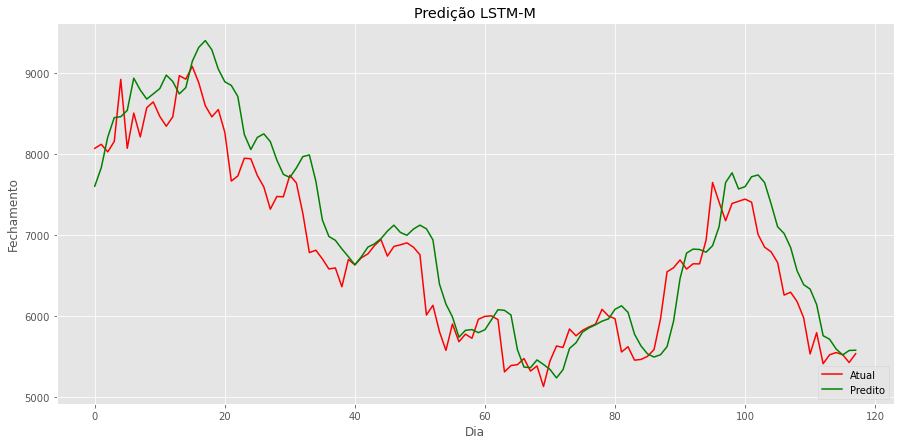

Split 3
MAE = 0.002987542869383881
MSE = 1.7700364755041075e-05
RMSE = 0.0042071801429272165
R-Squared Score = 0.9347520617060101


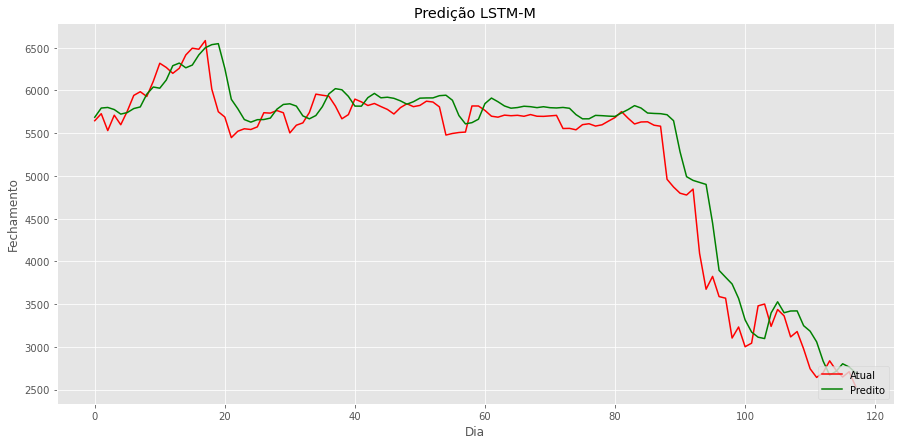

Split 4
MAE = 0.0015113319458616725
MSE = 6.195017482255712e-06
RMSE = 0.0024889792048660656
R-Squared Score = 0.8478392853598573


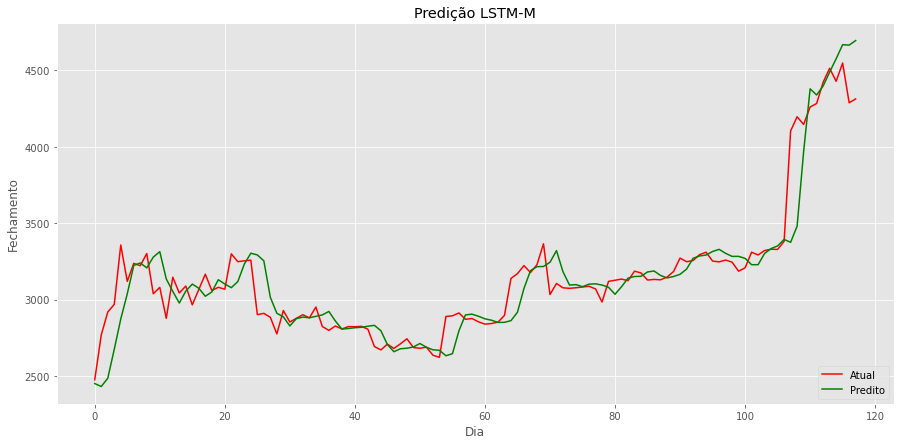

Split 5
MAE = 0.006824494342264206
MSE = 8.218822835043912e-05
RMSE = 0.009065772352670186
R-Squared Score = 0.9260286773782084


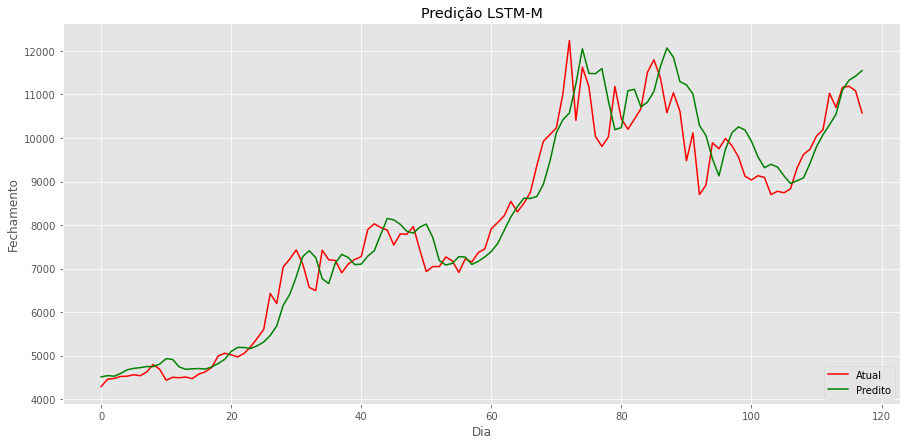

In [234]:
#Chamada da função
splits = 5
split_size = 120
cross_val_results = cross_val_forward_walk_batch(splits,split_size, series)

In [235]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Média MAE = {}".format(CV_temp['MAE'].mean()))
print("Média MSE = {}".format(CV_temp['MSE'].mean()))
print("Média RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Média R2 = {}".format(CV_temp['R2_Score'].mean()))


Média MAE = 0.0055173608059544835
Média MSE = 7.291675560156004e-05
Média RMSE = 0.007415681846034609
Média R2 = 0.8818727553257014
